## PhoPQ Activation Model

Kenny Groszman, in collaboration with Kathryn Brink of Rice University Department of Bioengineering

Here, we produce a model that predicts PhoPQ activation by cathelicidin-like peptides, based on a set of autoatically generated physical features from a library of peptides

The model is structured as follows:

- **Data import and cleaning**
    - Determine closest parent human AMP for each candidate sequence
    - Filter out peptides with no human AMP parent based on longest contiguous subsequence
    - Create a dataset with only cathelicidin-like (LL37-like) peptides
- **Feature selection**
    - Remove redundant and unnecessary features from the dataset
- **Model generation**
    - Cross-validate hyperparameters for a sparse and robust linear model
    - Validate results on holdout set
- **Create and save relevant outputs**

### Inport packages and add processing power

In [1]:
using CSV, DataFrames, Plots, Statistics, JLD2, Distributed, Random, PyCall, ScikitLearn
@sk_import model_selection: ShuffleSplit;
addprocs(4) #add processing power
IJulia.clear_output();

Julia version: `1.5.3`

Julia packages used:

- For file reading and writing: [`CSV @v0.8.3`](https://csv.juliadata.org/stable/)
- For data manipulation:  [`DataFrames @v0.22.1`](https://dataframes.juliadata.org/stable/)
- For data visualization: [`Plots @v1.10.5`](http://docs.juliaplots.org/latest/)
- For basic statistical functions (e.g., correlation): [`Statistics @v1.5`](https://docs.julialang.org/en/v1/stdlib/Statistics/)
- For saving and loading Julia objects: [`JLD2 @v0.4.1`](https://github.com/JuliaIO/JLD2.jl)
- For distributed computing: [`Distributed @v1.5`](https://docs.julialang.org/en/v1/manual/distributed-computing/)
- For access to random variables and permutations: [`Random @v1.5`](https://docs.julialang.org/en/v1/stdlib/Random/)
- For interpretable machine learning algorithms: [`Interpretable AI @v2.1.0`](https://docs.interpretable.ai/stable/)
- For shuffled cross validation: [`ScikitLearn @v0.6.3`](https://scikitlearnjl.readthedocs.io/en/latest/)
- For accessing Python-based functions (e.g., SKLearn): [`PyCall @v1.92.2`](https://github.com/JuliaPy/PyCall.jl)



## Data Import and Cleaning

### Import Data

In [15]:
# Import dataframe
df = CSV.read("data/peptide_features.tsv", delim='\t', DataFrame);

rename!(df, :Column1 => :Sequence); #rename sequence column

In [16]:
println("DF: ", size(df))
n_seq = size(df)[1];

DF: (3495, 1286)


In [17]:
# Import human AMP parent sequences

parent_df = CSV.read("../0. Data/peptides_df_clustered.csv", DataFrame);

println("Parent DF: ", size(parent_df))
n_parents = size(parent_df)[1];

Parent DF: (117, 4)


### Find parent sequence with longest contiguous subsequence for each peptide

In [18]:
###
# define function for longest contiguous subsequence
###

# Source: https://github.com/WestleyArgentum/Subsequences.jl

function longest_contiguous_subsequence(a, b)
    m = zeros(Int, length(a) + 1, length(b) + 1)
    longest, x_longest, y_longest = 0, 0, 0

    for x in 2:(length(a) + 1)
        for y in 2:(length(b) + 1)

            if a[x - 1] == b[y - 1]
                m[x, y] = m[x - 1, y - 1] + 1

                if m[x, y] > longest
                    longest = m[x, y]
                    x_longest = x
                    y_longest = y
                end
            else
                m[x, y] = 0
            end

        end
    end

    a_range = (x_longest - longest):(x_longest - 1)
    b_range = (y_longest - longest):(y_longest - 1)
    a[a_range], a_range, b_range
end


longest_contiguous_subsequence (generic function with 1 method)

In [19]:
###
# Find the closest human AMP parent for each peptide
###

# initialize output arrays
seq_parent = []
seq_parent_cluster = zeros(n_seq)
seq_parent_lcs = zeros(n_seq)


s=0

for i in eachrow(df)
    s=s+1

    lcs_array = zeros(n_parents)
    c = 1
    
    seq_len = length(i[:Sequence])
    
    for p in eachrow(parent_df)
        lcs_array[c] = length(longest_contiguous_subsequence(i[:Sequence], p[:Sequence])[1])
        c=c+1
    end
    
    i_max_match = argmax(lcs_array)
    
    seq_parent_lcs[s] = lcs_array[i_max_match]
    push!(seq_parent, parent_df[i_max_match, :Sequence])
    seq_parent_cluster[s] = parent_df[i_max_match, :Cluster]

end


In [20]:
###
# Create df_matched table with original features and new LCS / parents columns
###

df_matched = deepcopy(df)

df_matched.Parent_Sequence = seq_parent
df_matched.Parent_Cluster = seq_parent_cluster
df_matched.LCS = seq_parent_lcs

println("DF Size: ", size(df))
println("DF Matched Size: ", size(df_matched))

DF Size: (3495, 1286)
DF Matched Size: (3495, 1289)


### Visualize results

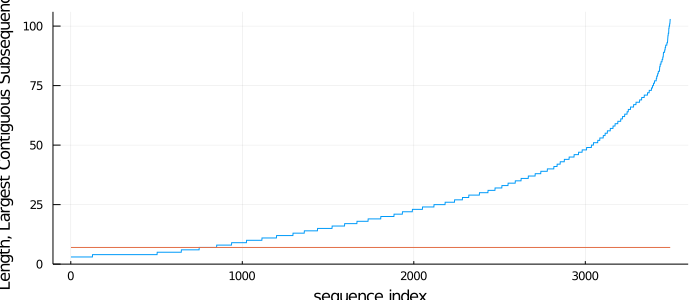

In [21]:
match = deepcopy(seq_parent_lcs)
sort!(match)
plot(match, legend=false, size = (700, 300), xlabel = "sequence index", ylabel = "Length, Largest Contiguous Subsequence")
plot!(ones(size(match))*7)

In [22]:
###
#Set threshold for minimum common subset to be considered a match
###

LCS_threshold = 7 # match must be at least 7 contiguous sequences to be considered a match


df_matched.Is_Matched = map(eachrow(df_matched)) do r
    if r.LCS >= LCS_threshold
        return 1
    else
        0
    end
end

df_matched.Adj_Cluster = map(eachrow(df_matched)) do r
    if r.Is_Matched == 1
        return Int(r.Parent_Cluster)
    else
        -999 #label column with cluster -999 if no match
    end
end;


In [23]:
# Visualize  # of peptides per cluster

first(sort(combine(groupby(df_matched, :Adj_Cluster), nrow), :nrow, rev=true), 10)

,Adj_Cluster,nrow
,Int64,Int64
1,-999,748
2,5,410
3,10,177
4,88,165
5,51,97
6,98,74
7,80,72
8,75,72
9,2,57


### Output sequences and clusters

In [24]:
###
# Output df to sanity check
###

output_df = select(df_matched, [:Sequence, :Parent_Sequence, :LCS, :Parent_Cluster, :Adj_Cluster]);

CSV.write("clustering_results_vF.csv", output_df)

"clustering_results_vF.csv"

### Prepare dataset with all sequences and clusters

Note: Although we will ultimately build a model just for LL-37-like AMPs, we prepare a dataset that includes all clusters since we will use this to validate the generalizability of the model

In [25]:
###
# Prepare data for model by doing the following:
# 0. Remove rows with no matching cluster
# 1. Split into X and Y (and remove superfluous columns)
# 2. Split into Train and Test
###


df_model = deepcopy(df_matched) # size: (3495, 1291)

# Filter -999 cluster
df_full = filter(row -> row.Adj_Cluster != -999 , df_model ); # size: (2747, 1291) 

# Remove superfluous columns and separate columns into X and Y
X_full = select(df_full, Not([:FoldChange, :Parent_Cluster, :Parent_Sequence]));
Y_full = Array{Float64}(df_full.FoldChange);

size(df_full)

(2747, 1291)

In [26]:
###
# Create dataset with just LL-37-like sequences
### 

#filter out just LL-37 cluster (cluster 5)
df_LL37 =  filter(row -> row.Adj_Cluster == 5 , df_model ); # (410, 1291)

# Remove superfluous columns and separate columns into X and Y
X_LL37 = select(df_LL37, Not([:FoldChange, :Parent_Cluster, :Parent_Sequence])); # size: (410, 1288) 
Y_LL37 = Array{Float64}(df_LL37.FoldChange); #size (410,)

println("Size of X_LL37: ", size(X_LL37))

Size of X_LL37: (410, 1288)


### Split into training and test set

In [30]:
# Split into Train and Test
(cv_X, cv_y), (test_X, test_y) = IAI.split_data(:regression, X_LL37, Y_LL37, train_proportion=.75);


## Feature Selection

In [31]:
###
# Create a dataframe to track dropped columns
###

dropped_columns_hist = DataFrame(
    ColumnName = Symbol[],
    Reason_Dropped = String[]
)

,ColumnName,Reason_Dropped
,Symbol,String


##### Create helper function to be used throughout feature selection and model creation

In [2]:
###
# Define helper functions to be used theoughout
###

function get_ready_X(X)
    ### Function to remove columns from X dataframe which are not to be used for modeling
    
    del_cols = [:Sequence, :LCS, :Adj_Cluster, :Is_Matched]
    X2 = select(X, Not(del_cols))
    return X2
end


function get_log_y(y)
    ### Function to process response variable for running model
    
    return log10.(y)
end

function get_r2(real_y, predict_y)
    ### Calcualte r2 validation metric
    
    ssr = sum((predict_y .- real_y).^2)
    sst = sum((real_y .- mean(real_y)).^2)
    return 1 - ssr/sst
end


get_r2 (generic function with 1 method)

#### Remove any features with zero variance


In [32]:
cv_X_f1 = deepcopy(cv_X) # make the first filtered version of cv_X

colnames = propertynames(cv_X)

drop_cols = []

for i = 1:length(colnames)
    if colnames[i] ∉ [:Sequence, :LCS, :Is_Matched, :Adj_Cluster]
        col_variance = Statistics.var(cv_X[:,colnames[i]])
        
        if col_variance < 0.000001
            println("Column $(colnames[i]) has variance of $col_variance. Removing from dataset.")
            push!(drop_cols, colnames[i])
        end
        
    end
end

cv_X_f1 = select(cv_X_f1, Not(drop_cols)) #filter out columns with zero variance


println("\nSize of cv_X: ", size(cv_X))
println("Size of cv_X_f1: ", size(cv_X_f1))



Column AE has variance of 0.0. Removing from dataset.
Column AM has variance of 0.0. Removing from dataset.
Column AV has variance of 0.0. Removing from dataset.
Column CA has variance of 0.0. Removing from dataset.
Column CC has variance of 0.0. Removing from dataset.
Column CE has variance of 0.0. Removing from dataset.
Column CG has variance of 0.0. Removing from dataset.
Column CM has variance of 0.0. Removing from dataset.
Column CV has variance of 0.0. Removing from dataset.
Column DA has variance of 0.0. Removing from dataset.
Column DC has variance of 0.0. Removing from dataset.
Column DG has variance of 0.0. Removing from dataset.
Column DH has variance of 0.0. Removing from dataset.
Column DM has variance of 0.0. Removing from dataset.
Column DW has variance of 0.0. Removing from dataset.
Column EH has variance of 0.0. Removing from dataset.
Column EM has variance of 0.0. Removing from dataset.
Column EV has variance of 0.0. Removing from dataset.
Column EW has variance of 0.

In [33]:
# Append removed columns into dropped columns dataframe

for i = 1 : length(drop_cols)
    push!(dropped_columns_hist, [drop_cols[i], "Zero Variance"])
end

dropped_columns_hist;

#### Remove pairwise correlated features

In [34]:
function remove_pairwise_correlated_columns(X::DataFrame, y, ρ_max)
    # return X2 DF without any pairwise correlated columns. Keep column with best relation to y
    
    X2 = deepcopy(X)
    drop_col_list = []
    drop_col_reason = []

    function get_cor_X(X)
        cor_X = cor(Matrix(X));
        
        for i = 1:size(cor_X)[1]
           cor_X[i,i] = 0 
        end
        return cor_X
    end
    
    function get_cor_y(X2, y)
        #correlation of each feature with y
        cor_y = []
        for i = 1 : size(X2)[2]
            push!(cor_y, cor(X2[:,i], y))
        end
        return cor_y
    end
    
    
    loop_flag = true
    
    while loop_flag
        
        # get latest matrices
        cor_X = get_cor_X(X2)
        cor_y = get_cor_y(X2, y)
        colnames = propertynames(X2)
       
        # Get the highest correlated pair
        max_pair = argmax(abs.(cor_X))
        i, j = max_pair[1], max_pair[2]
        println("--------")
        println("Found matching pair: $(colnames[i]) and $(colnames[j]) with ρ = $(cor_X[i,j])")
        
        
        if abs.(cor_X[i,j]) >= ρ_max
            
            # pick which column to drop based on absolute value of corrlation
            if abs(cor_y[j]) < abs(cor_y[i])
                drop_col = colnames[j]
            else
                drop_col = colnames[i]
            end
            println("Column $(colnames[i]) has y-corr $(cor_y[i])")
            println("Column $(colnames[j]) has y-corr $(cor_y[j])")
            println("Dropping column $drop_col ")

            # drop column
            X2 = select(X2, Not(drop_col))
            push!(drop_col_list, drop_col)
            push!(drop_col_reason, "Pairwise ρ = $(cor_X[i,j]) between $(colnames[i]) and $(colnames[j])")

        else #EXIT LOOP
            loop_flag = false
            
        end
    end
    
    return X2, drop_col_list, drop_col_reason

end

remove_pairwise_correlated_columns (generic function with 1 method)

In [35]:
###
# Run function to remove pairwise correlated columns of X
###


ρ_max = 0.95

~, f2_drop_cols, f2_drop_cols_reason = remove_pairwise_correlated_columns(get_ready_X(cv_X_f1), get_log_y(cv_y), ρ_max);

--------
Found matching pair: NW and AG with ρ = 1.0
Column NW has y-corr 0.015371926944655565
Column AG has y-corr 0.015371926944655565
Dropping column NW 
--------
Found matching pair: AY and AH with ρ = 1.0
Column AY has y-corr -0.06919433957000783
Column AH has y-corr -0.06919433957000783
Dropping column AY 
--------
Found matching pair: CH and AH with ρ = 1.0
Column CH has y-corr -0.06919433957000783
Column AH has y-corr -0.06919433957000783
Dropping column CH 
--------
Found matching pair: PA and AH with ρ = 1.0
Column PA has y-corr -0.06919433957000783
Column AH has y-corr -0.06919433957000783
Dropping column PA 
--------
Found matching pair: TH and CQ with ρ = 1.0
Column TH has y-corr -0.07344086300858872
Column CQ has y-corr -0.07344086300858872
Dropping column TH 
--------
Found matching pair: DT and DD with ρ = 1.0
Column DT has y-corr -0.0696489480146618
Column DD has y-corr -0.0696489480146618
Dropping column DT 
--------
Found matching pair: EY and DD with ρ = 1.0
Column 

--------
Found matching pair: pc(T,K) and pc(K,T) with ρ = -1.0
Column pc(T,K) has y-corr -0.6244922971495606
Column pc(K,T) has y-corr 0.6244922971495604
Dropping column pc(K,T) 
--------
Found matching pair: pc(S,Q) and pc(Q,S) with ρ = -1.0
Column pc(S,Q) has y-corr -0.6052320038725801
Column pc(Q,S) has y-corr 0.6052320038725801
Dropping column pc(S,Q) 
--------
Found matching pair: pc(S,R) and pc(R,S) with ρ = -1.0
Column pc(S,R) has y-corr -0.7547586833814058
Column pc(R,S) has y-corr 0.7547586833814058
Dropping column pc(S,R) 
--------
Found matching pair: FC and CF with ρ = 0.9999999999999999
Column FC has y-corr -0.09005322528279516
Column CF has y-corr -0.09005322528279516
Dropping column FC 
--------
Found matching pair: PE and CF with ρ = 0.9999999999999999
Column PE has y-corr -0.09005322528279516
Column CF has y-corr -0.09005322528279516
Dropping column PE 
--------
Found matching pair: WY and HW with ρ = 0.9999999999999999
Column WY has y-corr -0.15187179085132815
Column

Dropping column taugrant9 
--------
Found matching pair: MoranAuto_ResidueASA3 and MoranAuto_Polarizability3 with ρ = 0.9798490033675694
Column MoranAuto_ResidueASA3 has y-corr -0.5710991142309934
Column MoranAuto_Polarizability3 has y-corr -0.6036002689238781
Dropping column MoranAuto_ResidueASA3 
--------
Found matching pair: tausw3 and tausw10 with ρ = 0.9794261999914
Column tausw3 has y-corr -0.22080590202615688
Column tausw10 has y-corr -0.282947323343734
Dropping column tausw3 
--------
Found matching pair: IP and HA with ρ = 0.9793977048409853
Column IP has y-corr -0.09481592524407755
Column HA has y-corr -0.08362946300121715
Dropping column HA 
--------
Found matching pair: PAAC11 and L with ρ = 0.9792803533275647
Column PAAC11 has y-corr -0.4222399228357567
Column L has y-corr -0.31613031196527863
Dropping column L 
--------
Found matching pair: MoranAuto_Hydrophobicity1 and GearyAuto_Hydrophobicity1 with ρ = -0.9788869020676187
Column MoranAuto_Hydrophobicity1 has y-corr -0.2

--------
Found matching pair: MoranAuto_ResidueASA5 and MoranAuto_Polarizability5 with ρ = 0.968954626333662
Column MoranAuto_ResidueASA5 has y-corr 0.19997150275296985
Column MoranAuto_Polarizability5 has y-corr 0.23641060758600302
Dropping column MoranAuto_ResidueASA5 
--------
Found matching pair: MoreauBrotoAuto_ResidueASA2 and MoreauBrotoAuto_ResidueASA1 with ρ = 0.9688527940032948
Column MoreauBrotoAuto_ResidueASA2 has y-corr -0.23319950673630888
Column MoreauBrotoAuto_ResidueASA1 has y-corr -0.3295912965497118
Dropping column MoreauBrotoAuto_ResidueASA2 
--------
Found matching pair: _PolarityC1 and _HydrophobicityC3 with ρ = 0.9687835253359237
Column _PolarityC1 has y-corr 0.008972348695837908
Column _HydrophobicityC3 has y-corr 0.11245118402594408
Dropping column _PolarityC1 
--------
Found matching pair: tausw10 and tausw1 with ρ = 0.9687025057699963
Column tausw10 has y-corr -0.282947323343734
Column tausw1 has y-corr -0.14159680118542559
Dropping column tausw1 
--------
Fou

Dropping column _HydrophobicityD3100 
--------
Found matching pair: IH and HW with ρ = 0.9576448955564659
Column IH has y-corr -0.15982638139150065
Column HW has y-corr -0.15187179085132815
Dropping column HW 
--------
Found matching pair: pc(C,T) and pc(C,S) with ρ = 0.9576256493961678
Column pc(C,T) has y-corr -0.17250300602258187
Column pc(C,S) has y-corr -0.10686377762403866
Dropping column pc(C,S) 
--------
Found matching pair: MoranAuto_Polarizability2 and GearyAuto_Polarizability2 with ρ = -0.9575881855685208
Column MoranAuto_Polarizability2 has y-corr 0.5315597649799609
Column GearyAuto_Polarizability2 has y-corr -0.532474022490707
Dropping column MoranAuto_Polarizability2 
--------
Found matching pair: pc(A,R) and PAAC1 with ρ = 0.9575845619878907
Column pc(A,R) has y-corr -0.523999100382898
Column PAAC1 has y-corr -0.5209483248289033
Dropping column PAAC1 
--------
Found matching pair: pc(R,A) and pc(A,R) with ρ = -0.9569968771365525
Column pc(R,A) has y-corr 0.53702302570575

In [36]:
# Append into dropped columns dataframe
for i = 1 : length(f2_drop_cols)
    push!(dropped_columns_hist, [f2_drop_cols[i], f2_drop_cols_reason[i]])
end

dropped_columns_hist

,ColumnName,Reason_Dropped
,Symbol,String
1,AE,Zero Variance
2,AM,Zero Variance
3,AV,Zero Variance
4,CA,Zero Variance
5,CC,Zero Variance
6,CE,Zero Variance
7,CG,Zero Variance
8,CM,Zero Variance
9,CV,Zero Variance


In [37]:
#apply dropped columns from second filtering step
cv_X_f2 = deepcopy(cv_X_f1)
cv_X_f2 = select(cv_X_f2, Not(f2_drop_cols)); #size: (308, 988)
size(cv_X_f2)

(308, 982)

## Generate Sparse and Robust Linear Model

In [38]:
# check sizes makes sense
size(cv_X_f2) #size: (308, 979)
size(cv_y) # size 308

(308,)

In [40]:
function sparsity_cross_validation(k_vals, γ_vals, folds, cv_X, cv_y)
    ### Function to run shuffled cross validation for various values of sparsity (k) and regularizaition (γ)
    ### Return the parameters for the best model


    fold_hist = []
    k_hist = []
    γ_hist = []
    train_mse_hist = []
    valid_mse_hist = []

    fold = 0

    scv = ShuffleSplit(n_splits = folds, test_size = 0.25)

    for (train, validation) in scv.split(Matrix(get_ready_X(cv_X)), get_log_y(cv_y))
        fold = fold + 1

        # adjust train  / validation indexing to work with Julia (idx starting at 1) 
        train_idx = train .+ 1
        validation_idx = validation .+ 1

        for i = 1:length(k_vals), j = 1:length(γ_vals)

            #train model on fold with selected sparsity
            lnr = IAI.OptimalFeatureSelectionRegressor(sparsity = k_vals[i], gamma = γ_vals[j])
            IAI.fit!(lnr, get_ready_X(cv_X)[train_idx,:], get_log_y(cv_y)[train_idx] )

            # store results
            push!(fold_hist, fold)
            push!(k_hist, k_vals[i])
            push!(γ_hist, γ_vals[j])
            push!(train_mse_hist, IAI.score(lnr, get_ready_X(cv_X)[train_idx,:], get_log_y(cv_y)[train_idx], criterion = :mse))
            push!(valid_mse_hist,  IAI.score(lnr, get_ready_X(cv_X)[validation_idx,:], get_log_y(cv_y)[validation_idx], criterion = :mse))
        end

    end

    grid_search_result = DataFrame(
        :Fold => fold_hist, 
        :k => k_hist,
        :γ => γ_hist,
        :Train_MSE => train_mse_hist,
        :Valid_MSE => valid_mse_hist,
    )

    cross_val_summary = combine(groupby(grid_search_result, [:k, :γ]), 
        :Train_MSE => mean => :Avg_Train_MSE,
        :Train_MSE => std => :SD_Train_MSE,
        :Valid_MSE => mean => :Avg_Valid_MSE,
        :Valid_MSE => std => :SD_Valid_MSE,
)
    
    best_k_idx = argmax(cross_val_summary[:,:Avg_Valid_MSE])
    
    best_k = cross_val_summary[best_k_idx, :k]

    return cross_val_summary, grid_search_result, best_k
end


sparsity_cross_validation (generic function with 1 method)

### Coarse parameter search

In [41]:
#set parameters for hyperparameter tuning
k_vals = 1:10:401;
γ_vals = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

folds = 15;

In [42]:
grid_df, detailed_results, best_k = sparsity_cross_validation(k_vals, γ_vals, folds, cv_X_f2, cv_y)
grid_df

┌ Warning: This copy of Interpretable AI software is for academic purposes only and not for commercial use.
└ @ IAILicensing C:\Users\iai\builds\InterpretableAI\SystemImage\SysImgBuilder\.julia\packages\IAILicensing\1kPoM\src\precompile.jl:19


,k,γ,Avg_Train_MSE,SD_Train_MSE,Avg_Valid_MSE,SD_Valid_MSE
,Any,Any,Float64,Float64,Float64,Float64
1,1,0.001,0.208251,0.00737981,0.170344,0.0396532
2,1,0.005,0.480483,0.0170269,0.416433,0.0515402
3,1,0.01,0.556448,0.0197189,0.480469,0.0566905
4,1,0.05,0.60845,0.0215617,0.516318,0.0676667
5,1,0.1,0.611284,0.0216621,0.516405,0.0704084
6,1,0.5,0.612293,0.0216979,0.515054,0.0730295
7,11,0.001,0.637044,0.0146143,0.570285,0.0423715
8,11,0.005,0.807673,0.0100516,0.750311,0.0476237
9,11,0.01,0.835454,0.0107627,0.772993,0.0437155


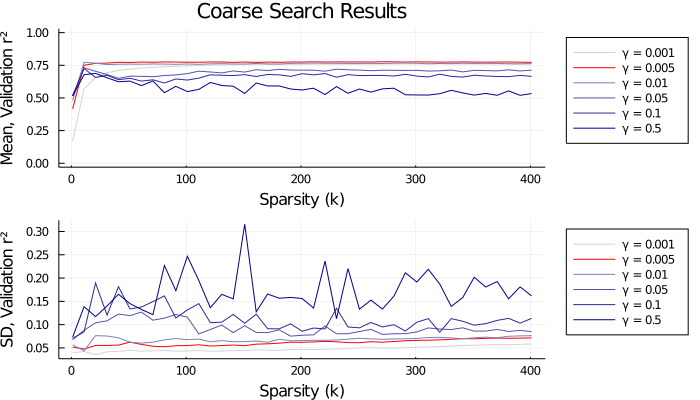

In [43]:
n = length(γ_vals)
colors = reshape( range(colorant"lightgray", stop=colorant"darkblue",length=n), 1, n );
p = plot(xlabel = "Sparsity (k)", ylabel  = "Mean, Validation r²", legend = :outerright, ylim = [0,1], title = "Coarse Search Results")


for i = 1:length(γ_vals)
    temp_df = filter(row -> row.γ == γ_vals[i], grid_df)
    if  γ_vals[i] == 0.005
        p = plot!(temp_df.k, temp_df.Avg_Valid_MSE, label = "γ = $( γ_vals[i])", linecolor = :red)
    else
        p = plot!(temp_df.k, temp_df.Avg_Valid_MSE, label = "γ = $( γ_vals[i])", linecolor = colors[i])
    end
        
end

q = plot(xlabel = "Sparsity (k)", ylabel  = "SD, Validation r²", legend = :outerright)
for i = 1:length(γ_vals)
    temp_df = filter(row -> row.γ == γ_vals[i], grid_df)
    if  γ_vals[i] == 0.005
        q = plot!(temp_df.k, temp_df.SD_Valid_MSE, label = "γ = $( γ_vals[i])", linecolor = :red)
    else
        q = plot!(temp_df.k, temp_df.SD_Valid_MSE, label = "γ = $( γ_vals[i])", linecolor = colors[i])
    end
end

plot(p, q, layout = (2,1), size = (700, 400))

From these plots, we first notice that at $\gamma = 0.005$, we get the best mean validation score with a low # of features with the lowest sd of validatior performance

Holding $\gamma = 0.005$ constant, we zoom on in $k \in [15, 70]$, where we see performance start to plateau, and we conduct the fine parameter search within this range. We also conduct a fine search near $\gamma = 0.005$

### Fine hyperparameter search

In [44]:
k_vals_fine = 5:1:70;
γ_vals_fine = [0.0025, 0.00375, 0.005, 0.00625, 0.0075] 
folds_fine = 15;

In [45]:
fine_grid_df, fine_detailed_results, best_k = sparsity_cross_validation(k_vals_fine, γ_vals_fine, folds_fine, cv_X_f2, cv_y)
fine_grid_df

,k,γ,Avg_Train_MSE,SD_Train_MSE,Avg_Valid_MSE,SD_Valid_MSE
,Any,Any,Float64,Float64,Float64,Float64
1,5,0.0025,0.646671,0.0148214,0.613651,0.0314011
2,5,0.00375,0.708347,0.0144957,0.668494,0.0380582
3,5,0.005,0.740555,0.011087,0.703981,0.0407962
4,5,0.00625,0.756488,0.00940837,0.724951,0.0386423
5,5,0.0075,0.769255,0.0121085,0.729611,0.0522511
6,6,0.0025,0.684383,0.00881335,0.64794,0.0351092
7,6,0.00375,0.732079,0.0111621,0.692421,0.0403371
8,6,0.005,0.759952,0.0135185,0.725488,0.0407594
9,6,0.00625,0.775839,0.0114599,0.744318,0.0404938


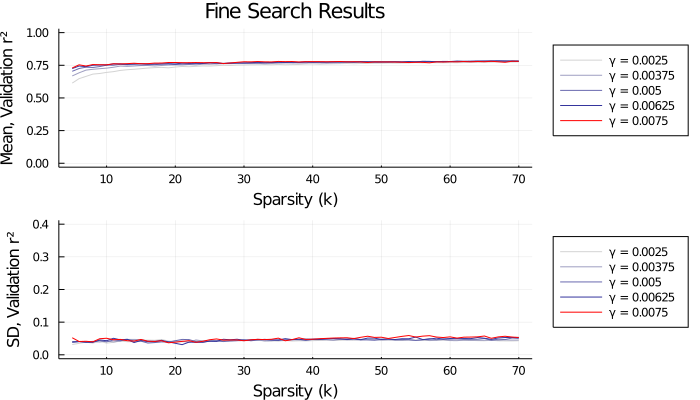

In [46]:
###
# Plotting Fine Grid Results, Option 1
###

n = length(γ_vals_fine)
colors = reshape( range(colorant"lightgray", stop=colorant"darkblue",length=n), 1, n );
p = plot(xlabel = "Sparsity (k)", ylabel  = "Mean, Validation r²", legend = :outerright, ylim = [0,1], title = "Fine Search Results")


for i = 1:length(γ_vals_fine)
    temp_df = filter(row -> row.γ == γ_vals_fine[i], fine_grid_df)
    if  γ_vals_fine[i] == 0.0075
        p = plot!(temp_df.k, temp_df.Avg_Valid_MSE, label = "γ = $( γ_vals_fine[i])", linecolor = :red)
    else
        p = plot!(temp_df.k, temp_df.Avg_Valid_MSE, label = "γ = $( γ_vals_fine[i])", linecolor = colors[i])
    end
        
end

q = plot(xlabel = "Sparsity (k)", ylabel  = "SD, Validation r²", legend = :outerright, ylim = [0, .4])
for i = 1:length(γ_vals_fine)
    temp_df = filter(row -> row.γ == γ_vals_fine[i], fine_grid_df)
    if  γ_vals_fine[i] == 0.0075
        q = plot!(temp_df.k, temp_df.SD_Valid_MSE, label = "γ = $( γ_vals_fine[i])", linecolor = :red)
    else
        q = plot!(temp_df.k, temp_df.SD_Valid_MSE, label = "γ = $( γ_vals_fine[i])", linecolor = colors[i])
    end
end

plot(p, q, layout = (2,1), size = (700, 400))

In [321]:
###
# Picking final parameters
###

best_row = filter(row -> row.Avg_Valid_MSE == maximum(fine_grid_df.Avg_Valid_MSE), fine_grid_df)

best_row.Avg_Valid_MSE

candidate_models = filter(row -> row.Avg_Valid_MSE >=  0.90* maximum(fine_grid_df.Avg_Valid_MSE), fine_grid_df)

,k,γ,Avg_Train_MSE,SD_Train_MSE,Avg_Valid_MSE,SD_Valid_MSE
,Any,Any,Float64,Float64,Float64,Float64
1,12,0.0075,0.827534,0.0156221,0.68795,0.123078
2,13,0.0075,0.830608,0.0157735,0.697314,0.102834
3,14,0.005,0.816552,0.0135435,0.691093,0.102403
4,14,0.00625,0.829046,0.0127049,0.69116,0.117115
5,14,0.0075,0.837148,0.0159706,0.711095,0.0769932
6,15,0.005,0.821397,0.0135212,0.694742,0.0971714
7,15,0.00625,0.8318,0.0142265,0.695077,0.112279
8,15,0.0075,0.842647,0.0159285,0.699125,0.114578
9,16,0.005,0.826472,0.011545,0.69329,0.107706


We pick model with $k=14$ and $\gamma = 0.0075$. This particular configuration seems to have good performance and lower SD than some of its neighbors and it is more parsimonious

### Train final learner with selected parameters

In [49]:
lnr = IAI.OptimalFeatureSelectionRegressor(sparsity = 14, gamma = 0.0075)
IAI.fit!(lnr, get_ready_X(cv_X_f2), get_log_y(cv_y))

Fitted OptimalFeatureSelectionRegressor:
  Constant: -0.091034
  Weights:
    Charge:                            0.0292873
    GearyAuto_Hydrophobicity7:        -0.168851
    GearyAuto_Mutability3:             0.258336
    GearyAuto_ResidueASA8:            -0.215186
    KD:                                0.0267939
    MoranAuto_Hydrophobicity7:         0.212182
    MoreauBrotoAuto_Hydrophobicity10: -0.230089
    PAAC28:                            0.0525223
    PAAC29:                            0.0467
    RC:                                0.229127
    TS:                               -0.0364532
    _HydrophobicityD2001:             -0.00317889
    pc(G,R):                          -0.30862
    pc(T,K):                          -0.297545

### Evaluate results

##### Plot results

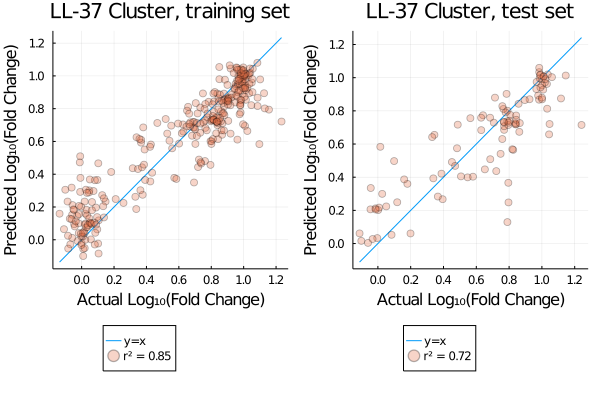

In [50]:
function evaluate_model(lnr, cv_X, cv_y, test_X, test_y)
    ### Plot training and test results, along with r2 value
    
    predict_y_cv = IAI.predict(lnr, get_ready_X(cv_X))
    predict_y_test = IAI.predict(lnr, get_ready_X(test_X))
    
    cv_full = deepcopy(cv_X)
    cv_full.real_y = get_log_y(cv_y)
    cv_full.predict_y = predict_y_cv
    
    test_full = deepcopy(test_X)
    test_full.real_y = get_log_y(test_y)
    test_full.predict_y = predict_y_test
    
    subplots = []

    #Overall
    r2 = round(get_r2(cv_full.real_y, cv_full.predict_y), digits=2)
    p = Plots.plot(cv_full.real_y, cv_full.real_y, label="y=x", xlabel="Actual Log₁₀(Fold Change)", ylabel="Predicted Log₁₀(Fold Change)", title = "LL-37 Cluster, training set")
    p = Plots.scatter!(cv_full.real_y, cv_full.predict_y, label="r² = $r2", legend=:outerbottom, markeralpha=0.3)
    push!(subplots, p)
    
        
    #Overall test
    r2 = round(get_r2(test_full.real_y, test_full.predict_y), digits=2)
    p = Plots.plot(test_full.real_y, test_full.real_y, label="y=x", xlabel="Actual Log₁₀(Fold Change)", ylabel="Predicted Log₁₀(Fold Change)", title = "LL-37 Cluster, test set")
    p = Plots.scatter!(test_full.real_y, test_full.predict_y, label="r² = $r2", legend=:outerbottom,markeralpha=0.3)
    push!(subplots, p)
    
    Plots.plot(subplots[1], subplots[2], layout=(1,2))
    
end

evaluate_model(lnr, cv_X, cv_y, test_X, test_y)

#### Test generalizability of model on other clusters

In [51]:
df_full.Actual_LFC = get_log_y(Y_full)
df_full.Predicted_LFC = IAI.predict(lnr, get_ready_X(X_full))

#summarize into table


cluster_df = combine(groupby(df_full, :Adj_Cluster), 
        nrow => :n, 
        :FoldChange => maximum => :Max_Cluster_FoldChange,
        [:Actual_LFC, :Predicted_LFC] => ((a,p) -> get_r2(a,p)) => :r2
);


sort(cluster_df, :r2, rev=true)

,Adj_Cluster,n,Max_Cluster_FoldChange,r2
,Int64,Int64,Float64,Float64
1,5,410,17.443,0.824741
2,48,45,6.50244,-0.0711292
3,30,9,4.91326,-0.163361
4,42,51,3.54122,-0.229037
5,91,29,2.48021,-0.319174
6,18,10,4.42966,-0.327
7,102,22,2.96934,-0.384212
8,29,45,9.32638,-0.397956
9,23,14,2.60096,-0.565698


#### Feature importance

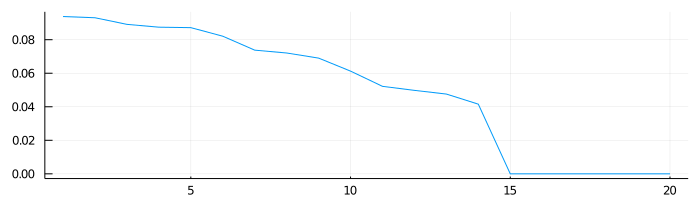

In [52]:
variable_importance = IAI.variable_importance(lnr)
plot(variable_importance.Importance[1:20], size=(700, 200), legend=false)

## Create and save relevant outputs

In [54]:
store_path = "Results_SparseLinearReg_20210319/";

In [55]:
###
# FEATURES REMOVED
###
CSV.write(store_path*"feature_selection_df.tsv", dropped_columns_hist, delim="\t");

In [56]:
###
# COARSE SEARCH RESULTS
###
grid_df_output = rename(grid_df, :γ => :gamma)

CSV.write(store_path*"coarse_search_results_data.tsv", grid_df_output, delim="\t");

In [57]:
###
# FINE SEARCH RESULTS
###

fine_grid_df_output = rename(fine_grid_df, :γ => :gamma)
fine_grid_df_output

CSV.write(store_path*"fine_search_results_data.tsv", fine_grid_df_output, delim="\t");

In [58]:
###
# PREDICTIONS FOR ALL CLUSTERS
###
# select!(cluster_df, Not(:r))

CSV.write(store_path*"results_by_cluster.tsv", cluster_df, delim="\t")

"Results_SparseLinearReg_20210319/results_by_cluster.tsv"

In [59]:
###
# PREDICTIONS FOR ALL AMPs
###

df_full_output = select(df_full, [:Sequence, :Adj_Cluster, :FoldChange, :Actual_LFC, :Predicted_LFC])

CSV.write(store_path*"predictions_all_AMPs.tsv", df_full_output, delim="\t")

"Results_SparseLinearReg_20210319/predictions_all_AMPs.tsv"

In [60]:
###
# PREDICTIONS FOR LL37-like AMPS
###

cv_X, cv_y, test_X, test_y

cv_LL37_full = deepcopy(cv_X)
cv_LL37_full.FoldChange = cv_y
cv_LL37_full.Actual_LFC = get_log_y(cv_y)
cv_LL37_full.Predicted_LFC = IAI.predict(lnr, get_ready_X(cv_X))
cv_LL37_full[!, :DataSet] .= "Train"

test_LL37_full = deepcopy(test_X)
test_LL37_full.FoldChange = test_y
test_LL37_full.Actual_LFC = get_log_y(test_y)
test_LL37_full.Predicted_LFC = IAI.predict(lnr, get_ready_X(test_X))
test_LL37_full[!, :DataSet] .= "Test"


LL37_full_df = vcat(cv_LL37_full, test_LL37_full)
size(LL37_full_df)

LL37_full_df_output = select(LL37_full_df, [:Sequence, :Adj_Cluster, :FoldChange, :Actual_LFC, :Predicted_LFC, :DataSet])

CSV.write(store_path*"predictions_LL37_AMPs.tsv", LL37_full_df_output, delim="\t")

"Results_SparseLinearReg_20210319/predictions_LL37_AMPs.tsv"

In [61]:
###
# FEATURE IMPORTANCES FINAL MODEL
###
variable_importance
CSV.write(store_path*"feature_importance_final_model.tsv", variable_importance, delim="\t")

"Results_SparseLinearReg_20210319/feature_importance_final_model.tsv"

In [63]:
###
# Store plots for each cluster
###

cluster_list = unique(df_full.Adj_Cluster)

for i = 1:length(cluster_list)
    temp_df = filter(row -> row.Adj_Cluster == cluster_list[i], df_full)
    
    r2 = round(get_r2(temp_df.Actual_LFC, temp_df.Predicted_LFC), digits=2)
    p = Plots.plot(temp_df.Actual_LFC, temp_df.Actual_LFC, label="y=x", xlabel="Actual Log₁₀(Fold Change)", ylabel="Predicted Log₁₀(Fold Change)", title = " Cluster $(cluster_list[i])")
    p = Plots.scatter!(temp_df.Actual_LFC, temp_df.Predicted_LFC, label="r² = $r2", legend=:outerbottom,markeralpha=0.3)
    png(store_path*"cluster_plots/cluster_$(cluster_list[i])")
end

In [96]:
###
# Save Model
###

@save "final_model.jld2" lnr

IAI.write_json("final_model_json.json", lnr)

376026